In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from timeit import default_timer
from collections import namedtuple
import pylab as plt
import os
import sys

import gpflow as gp

import astropy.coordinates as ac
import astropy.time as at
import astropy.units as au

from scipy.cluster.vq import kmeans2

from bayes_tec.frames import ENU
from bayes_tec.datapack import DataPack
from bayes_tec.utils.data_utils import make_coord_array, calculate_weights

plt.style.use('ggplot')
float_type = tf.float64
jitter = 1e-6




/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __n

In [2]:
from gpflow.transforms import Identity

class Parameter(object):
    def __init__(self, name, value, transform=Identity(), prior=None,
                 trainable=True, dtype=float_type, unconstrained_tensor=None):
        self.name = name
        self.prior = prior          # pylint: disable=W0201
        self.transform = transform  # pylint: disable=W0201
        if unconstrained_tensor is None:
            self._initial_value_tensor = tf.convert_to_tensor(value,dtype=dtype)
            self._unconstrained_tensor_ref = tf.get_variable(name, dtype=dtype, 
                    initializer=self.transform.backward_tensor(self._initial_value_tensor), 
                    trainable=trainable,
                    use_resource=True)
            self._unconstrained_tensor = tf.identity(self.unconstrained_tensor_ref)
        else:
            self._unconstrained_tensor_ref = None
            self._unconstrained_tensor = unconstrained_tensor
            self._initial_value_tensor = self.transform.forward_tensor(unconstrained_tensor)
        self._constrained_tensor = self.transform.forward_tensor(self.unconstrained_tensor)
        self._prior_tensor = self._build_prior(self.unconstrained_tensor, self.constrained_tensor)

    @property
    def unconstrained_tensor_ref(self):
        return self._unconstrained_tensor_ref
    
    @property
    def unconstrained_tensor(self):
        return self._unconstrained_tensor

    @property
    def constrained_tensor(self):
        return self._constrained_tensor

    @property
    def prior_tensor(self):
        """log P(constrained_param) + log |det transform(unconstrained_param)|"""
        return self._prior_tensor
  
    @property
    def initializer(self):
        if self.unconstrained_tensor_ref is None:
            raise ValueError("No variable referenced")
        return self.unconstrained_tensor_ref.initializer

    def assign_op(self, value):
        if self.unconstrained_tensor_ref is None:
            raise ValueError("No variable referenced")
        return tf.assign(self._unconstrained_tensor_ref,self.transform.backward_tensor(value))
        
    def _build_prior(self, unconstrained_tensor, constrained_tensor):
        prior_name = '{}_logp'.format(self.name)

        if self.prior is None:
            logp_param = tf.constant(0.0, float_type)
        else:
            logp_param = self.prior(constrained_tensor)

        log_jacobian = self.transform.log_jacobian_tensor(unconstrained_tensor)
        
        return tf.squeeze(tf.add(logp_param, log_jacobian, name=prior_name))
    
class Kernel(object):
    def __init__(self, time_lengthscale, dir_lengthscale, ant_lengthscale, dot_var, dot_offset,
                active_dims_time=None,active_dims_dir=None,active_dims_ant=None):
        self.dir_lengthscale = dir_lengthscale
        self.time_lengthscale = time_lengthscale
        self.ant_lengthscale = ant_lengthscale
        self.dot_var = dot_var
        self.dot_offset = dot_offset
        self.active_dims_time = active_dims_time or slice(0,1,1)
        self.active_dims_dir = active_dims_dir or slice(1,3,1)
        self.active_dims_ant = active_dims_ant or slice(3,5,1)
        
    def scaled_square_dist_batched(self,X, X2, lengthscale):
        """
        X: tensor B, N, D
        X2: tensor B, M, D (or 1, M, D) and will be broadcast to B, M ,D
        Return:
        tensor B, N, M
        """
        # Clipping around the (single) float precision which is ~1e-45.
        X = X / lengthscale
        Xs = tf.reduce_sum(tf.square(X), axis=2)#B,N

        if X2 is None:
            dist = -2.*tf.matmul(X,X,transpose_b=True)
            dist += Xs[:,:,None] + Xs[:,None,:]
            return tf.maximum(dist, 1e-40)

        # B (1), M, D
        X2 = X2 / lengthscale
        X2s = tf.reduce_sum(tf.square(X2), axis=2)# B (1), M 
        dist = -2 * tf.matmul(X, X2, transpose_b=True)
        dist += Xs[:,:,None] + X2s[:,None,:]
        return dist
    
    def scaled_square_dist(self,X, X2, lengthscale):
        """
        X: tensor N, D
        X2: tensor M, D
        Return:
        tensor N, M
        """
        # Clipping around the (single) float precision which is ~1e-45.
        X = X / lengthscale
        Xs = tf.reduce_sum(tf.square(X), axis=1)#N

        if X2 is None:
            dist = -2.*tf.matmul(X,X,transpose_b=True)
            dist += Xs[:,None] + Xs[None,:]
            return tf.maximum(dist, 1e-40)

        # M, D
        X2 = X2 / lengthscale
        X2s = tf.reduce_sum(tf.square(X2), axis=1)#  M 
        dist = -2 * tf.matmul(X, X2, transpose_b=True)
        dist += Xs[:,None] + X2s[None,:]
        return dist
    
    def _clipped_sqrt(self, r2):
        # Clipping around the (single) float precision which is ~1e-45.
        return tf.sqrt(tf.maximum(r2, 1e-40))

    
    def K(self, X, X2=None):
        """Returns the covariance at X and X2.
        (dot_offset + dot_var*X.X2) * M52(time) * RBF(dir) * M12(ant)
        Args:
        :param X: float Tensor [N, ndims]
        :param X2: float Tensor [M, ndims]
        Returns:
        float Tensor [N,M]
        """
        Xt = X[:,self.active_dims_time]
        Xd = X[:,self.active_dims_dir]
        Xa = X[:,self.active_dims_ant]
        
        if X2 is None:
            X2t = None
            X2d = None
            X2a = None
        else:
            X2t = X2[:,self.active_dims_time]
            X2d = X2[:,self.active_dims_dir]
            X2a = X2[:,self.active_dims_ant]
        
        
        r2t = self.scaled_square_dist(Xt, X2t, self.time_lengthscale)
        rt = self._clipped_sqrt(r2t)
        r2d = self.scaled_square_dist(Xd, X2d, self.dir_lengthscale)
        ra = self._clipped_sqrt(self.scaled_square_dist(Xa, X2a, self.ant_lengthscale))
        
        combined_exp = tf.accumulate_n([np.sqrt(5.)*rt, 0.5*r2d, ra])
        combined_exp = tf.exp(-combined_exp)
        dot_kern = self.dot_offset + self.dot_var * tf.matmul(Xd, Xd if X2d is None else X2d, transpose_b=True)
        time_m52 = (1. + np.sqrt(5.) * rt + (5./3.) * r2t)
        
        return combined_exp*dot_kern*time_m52
    
    def Kdiag(self, X):
        """Returns the diag of the covariance at X.
        Args:
        :param X: float Tensor [N, ndims]
        Returns:
        float Tensor [N]
        """
        return self.dot_var*tf.linalg.norm(X,axis=-1,keepdims=False) + self.dot_offset

def make_solsets(datapack,output_solset, screen_res=15, extend = 0., solset='sol000'):
    screen_solset = "screen_{}".format(output_solset)
    
    datapack.switch_solset(solset)
    datapack.select(ant=None,time=None, dir=None, freq=None, pol=slice(0,1,1))
    axes = datapack.__getattr__("axes_{}".format('phase'))

    antenna_labels, antennas = datapack.get_antennas(axes['ant'])
    patch_names, directions = datapack.get_sources(axes['dir'])
    timestamps, times = datapack.get_times(axes['time'])
    freq_labels, freqs = datapack.get_freqs(axes['freq'])
    pol_labels, pols = datapack.get_pols(axes['pol'])

    Npol, Nd, Na, Nf, Nt = len(pols), len(directions), len(antennas), len(freqs), len(times)
    
#     screen_directions = dialated_faceted(directions.ra.rad.mean(), directions.dec.rad.mean(),
#                                         N=screen_res)

    screen_ra = np.linspace(np.min(directions.ra.rad) - extend*np.pi/180., 
            np.max(directions.ra.rad) + extend*np.pi/180., screen_res)
    screen_dec = np.linspace(max(-90.*np.pi/180.,np.min(directions.dec.rad) - extend*np.pi/180.), 
            min(90.*np.pi/180.,np.max(directions.dec.rad) + extend*np.pi/180.), screen_res)
    screen_directions = np.stack([m.flatten() \
            for m in np.meshgrid(screen_ra, screen_dec, indexing='ij')], axis=1)
    screen_directions = ac.SkyCoord(screen_directions[:,0]*au.rad,screen_directions[:,1]*au.rad,frame='icrs')
    Nd_screen = screen_res**2

    datapack.switch_solset(output_solset, 
            array_file=DataPack.lofar_array, 
            directions = np.stack([directions.ra.rad,directions.dec.rad],axis=1), patch_names=patch_names)
    datapack.add_freq_indep_tab('tec', times.mjd*86400., pols = pol_labels)   
    datapack.add_freq_dep_tab('amplitude', times.mjd*86400., pols = pol_labels,freqs=freqs)
    datapack.add_freq_dep_tab('phase', times.mjd*86400., pols = pol_labels,freqs=freqs)


    datapack.switch_solset(screen_solset, 
            array_file = DataPack.lofar_array, 
            directions = np.stack([screen_directions.ra.rad,screen_directions.dec.rad],axis=1))
    datapack.add_freq_indep_tab('tec', times.mjd*86400., pols = pol_labels)
    datapack.add_freq_dep_tab('amplitude', times.mjd*86400., pols = pol_labels,freqs=freqs)
    datapack.add_freq_dep_tab('phase', times.mjd*86400., pols = pol_labels,freqs=freqs)

    datapack.switch_solset(solset)
    
def get_solset_coords(datapack,solset):
    datapack.switch_solset(solset)
    axes = datapack.axes_phase
    antenna_labels, antennas = datapack.get_antennas(axes['ant'])
    patch_names, directions = datapack.get_sources(axes['dir'])
    timestamps, times = datapack.get_times(axes['time'])
    pol_labels, pols = datapack.get_pols(axes['pol'])
    
    antennas_enu = antennas.transform_to(ENU(obstime=times[0],location=datapack.array_center))
    X_a = np.array([antennas_enu.east.value,
                    antennas_enu.north.value]).T/1000.
    X_d = np.array([directions.ra.deg - directions.ra.deg.mean(), directions.dec.deg - directions.dec.deg.mean()]).T
    X_t = (times.mjd*86400 - times[0].mjd*86400.)[:,None]
    
    return X_t, X_d, X_a

In [ ]:
UpdateResult = namedtuple('UpdateResult',['x_samples','z_samples','log_prob', 'acceptance','step_size'])

class TargetDistribution(object):
    def __init__(self, 
                 kerns, 
                 z_tm1, 
                 X_t, 
                 X_tm1, 
                 Y_t, 
                 freqs, 
                 L_tm1, 
                 num_chains,
                 max_lik=True, 
                 step_size=0.01,
                 Y_sigma=1.,
                 approximate_posterior = 'mfsg',
                 prior_opts = {}):
        """
        The target distribution of the Bayes filter.
        Args:
        :param z_tm1: float Tensor [S, num_chains, M, Np]
        :param X: float Tensor [N,K]
        :param last_X: float Tensor [Np, K]
        :param Y: float Tensor [D, N, Nf]
        :param Y_std: float Tensor [D, N, Nf]
        :param freqs: float Tensor [Nf]
        :param L11: float Tensor [M, Np, Np]
        """
        self.M = tf.shape(z_tm1)[2]
        self.S = tf.shape(z_tm1)[0]
        self.num_chains = num_chains
        self.N = tf.shape(Y_t)[1]
        self.Np = tf.shape(z_tm1)[-1]
        
        #M, N, N
        self.Kx_t = kerns[0](X_t)
        #M, N, N
        self.Kh_t = kerns[1](X_t)
        #M, Np, Np
        self.Kx_tm1 = kerns[0](X_tm1)
        #M, Np, Np
        self.Kh_tm1 = kerns[1](X_tm1)
        self.jitter = tf.convert_to_tensor(jitter,dtype=float_type,name='jitter')
        
        self.offset_t = self.jitter*tf.eye(self.N,dtype=float_type)
        self.offset_tm1 = self.jitter*tf.eye(self.Np,dtype=float_type)
        #M, N, N
        self.Lx_t = tf.cholesky(self.Kx_t + self.offset_t)
        #M, N, N
        self.Lh_t = tf.cholesky(self.Kh_t + self.offset_t)
        #M, Np, Np
        self.Lx_tm1 = tf.cholesky(self.Kx_tm1 + self.offset_tm1)
        #M, Np, Np
        self.Lh_tm1 = tf.cholesky(self.Kh_tm1 + self.offset_tm1)
        
        #M, Np, N
        self.Kx_tm1t = kern(X_tm1, X_t)
        #S, num_chains, M, N
        self.z_tm1 = z_tm1
        #D, N, Nf
        self.Y = Y
        #Nf
        self.freqs = freqs
        
        self.step_size = tf.get_variable(
                name='step_size',
                initializer=lambda: tf.constant(step_size,dtype=tf.float64),
                use_resource=True,
                dtype=tf.float64,
                trainable=False)
        
        self.Y_sigma = Y_sigma
        self.max_lik = max_lik
        self.approximate_posterior = approximate_posterior
        self.prior_opts = prior_opts
        
    def likelihood(self, x_t):
        """
        Calculate the likelihood of Y given hidden_state.
        I.e.
            sum_i log[P(Y_j(X_i) | X_i)]
        If Y_j in C^Nf and assuming independence between 
        real, imag, and components we get,
            sum_i sum_j log[P(Re[Y_j(X_i)] | X_i)] 
                        + log[P(imag[Y_j(X_i)] | X_i)]
        Args:
        :param x_t: float Tensor [num_chains, M, N+H]
        Returns:
        float Tensor [num_chains]
        """
        #num_chains, N
        x_t = x_t[:, 0, :self.N]
        #Nf
        tec_conv = tf.div(tf.cast(-8.448e6,tf.float64),self.freqs,name='tec_conv')
        #num_chains, N, Nf
        phi = tec_conv*x_t[:,:,None]
        g_real = tf.cos(phi)
        g_imag = tf.sin(phi)
        #D, num_chains, N, Nf
        g = tf.stack([g_real, g_imag],axis=0,name='g')
        L = tfp.distributions.MultivariateNormalDiag(loc=g, scale_identity_multiplier = self.sigma_amp,#scale_diag=self.sigma_amp*self.Y_std[:, None,:,:]
                                                     name='data_likelihood')        
        #D,num_chains, N
        logp = L.log_prob(self.Y[:,None,:,:])
        #num_chains
        return tf.reduce_sum(logp,axis=[0, 2])

    def _mfsg_logp(self,x_t,**prior_opts):
        '''
        Evaluates log probability of the predict step assuming
        a the mean field single Gaussian (MF) representing the 
        resulting mixture of Gaussians as a single Gaussian.
        It is less correct than the (MF) approximation
        but has complexity O(SM^2 + M^3).
        Args:
        :param x_t: float Tensor [num_chains, M, N]
        Returns:
        float Tensor [num_chains]
        '''
        pass
    
    def _mf_logp(self,x_t, num_sigma_points = 10,**prior_opts):
        '''
        Evaluates log probability of the predict step assuming
        a the mean field approximation (MF). It is the most correct
        approximation but also the highest complexity O(SM^3).
        Args:
        :param x_t: float Tensor [num_chains, M, N]
        Returns:
        float Tensor [num_chains]
        '''
        num_sigma_points = tf.convert_to_tensor(num_sigma_points, dtype=tf.int32)

        s = tf.minimum(num_sigma_points, tf.shape(self.z_tm1)[0])
        shuffle_index = tf.random_shuffle(tf.range(tf.shape(self.z_tm1)[0],dtype=tf.int32))[:s]
        #s, num_chains, M, Np
        z_tm1 = tf.gather(self.z_tm1, shuffle_index, axis=0,name='z_tm1')
        x_tm1 = tf.einsum('mij,snmj->snmi',self.L11, z_tm1)

        # log[P(Z_i | Z_i-1,s)] = log[N[m_i, C]] + log
        #M, Np, N
        A = tf.matrix_triangular_solve(self.L11,self.K10)
#         #s, num_chains, M, Np, N
#         A_expand = tf.tile(A[None, None, :, :, :], [s, self.num_chains,1,1,1])
#         #s, num_chains, M, N
#         m = tf.matmul(A_expand, z_tm1[:,:,:,:,None],transpose_a=True)[:,:,:,:,0]
        #s, num_chains, M, N
        m = tf.einsum('mij,snmi->snmj',A,x_tm1)
        #M, N, N
        C = self.K00 - tf.matmul(A, A, transpose_a=True)
        #M, N, N
        L = tf.cholesky(C + tf.cast(jitter,tf.float64)*tf.eye(tf.shape(C)[2],dtype=tf.float64))
        P = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=L[None, None,:,:,:])
        #s, num_chains, M
        log_prob = P.log_prob(x_t) - tf.reduce_sum(tf.log(tf.matrix_diag_part(self.L00)),axis=1)
        #s, num_chains
        log_prob = tf.reduce_sum(log_prob, axis=2)
        #num_chains
        log_prob = tf.reduce_logsumexp(log_prob,axis=0) - tf.log(tf.cast(s,tf.float64))
        log_prob.set_shape(tf.TensorShape([self.num_chains]))
        return log_prob
    
    def _gpp_logp(self,x_t,**prior_opts):
        '''
        Evaluates log probability of the predict step assuming
        a Gaussian previous posterior (GPP) and conditional 
        independence of the hyperparameters. In this case, 
        marginalisation is analytic.
        Args:
        :param x_t: float Tensor [num_chains, M, N]
        Returns:
        float Tensor [num_chains]
        '''
        #S, num_chains, M, Np,1
        x_tm1 = tf.einsum('mij,snmj->snmi',self.L11, self.z_tm1)[..., None]
        #num_chains, M, Np,1
        m_tm1 = tf.reduce_mean(x_tm1,axis=0)
        #num_chains, M, Np,Np
        m2 = tf.matmul(m_tm1,m_tm1, transpose_b=True)
        #num_chains, M, Np, Np
        C_tm1 = tf.reduce_mean(tf.matmul(x_tm1, x_tm1,transpose_b=True), axis=0) - m2
            
    
    def prior_logp(self, x_t):
        """
        Calculate the predict step, i.e.
            log[P(X_i | Y_i-1)] = log E_i-1[P(X_i | X_i-1)]
                                = log sum_s P(X_i | X_i-1,s) - log S
                                = logsumexp_s log[P(X_i | X_i-1,s)] - log S
            If we transform the variables through,
            X = L.Z + m => log P(X) = log P(Z) - log det L
            log[P(X_i | X_i-1,s)] = log[P(Z_i | Z_i-1,s)] - log det L_i
        Assumes hidden state is a GP marginal.
        Args:
        :param x_t: float Tensor [num_chains, M, N]
        Returns:
        [num_chains]
        """
        
        if self.approximate_posterior == 'mfsg':
            log_prob = self._mfsg_logp(x_t, **self.prior_opts)
        elif self.approximate_posterior == 'mf':
            log_prob = self._mf_logp(x_t,**self.prior_opts)
        elif self.approximate_posterior == 'gpp':
            log_prob = self._gpp_logp(x_t,**self.prior_opts)
            
        log_prob.set_shape(tf.TensorShape([self.num_chains]))
        return log_prob
    
    def unnormalized_logp(self,z_t):
        """
        Returns the unnormalized probability density of the Bayes filter posterior.
        log P(y_t | z_t) + log (1/S) sum_s P(z_t | z^s_t-1)
        Args:
        :param z_t: float Tensor [num_chains, M*(N+H)]
        Returns:
        [num_chains]
        """
        #num_chains, M, N+H
        z_t = tf.cast(tf.reshape(z_t,[self.num_chains, self.M, -1]),tf.float64)
        #num_chains, M, N+H
        x_t = tf.einsum('mij,nmj->nmi', self.L00, z_t)
        
#         #num_chains, M, N, N
#         L00_expand = tf.tile(self.L00[None, :, :self.N, :self.N], [self.num_chains, 1,1,1])
#         #num_chains, N
#         x_t = tf.matmul(L00_expand, z_t[:, :, :self.N, None])[:, 0, :, 0]

        #num_chains, N
        x_t = x_t[:, 0, :self.N]
        max_lik_logp = self.likelihood(x_t)
        full_post_logp = max_lik_logp + self.prior_logp(x_t)
        logp = tf.cond(self.max_lik,
                       lambda: max_lik_logp, 
                       lambda: full_post_logp)
        return logp#self.likelihood(x_t) + self.prior_logp(x_t)
    
    def sample(self,num_samples=10, step_size = 1., num_leapfrog_steps=2, target_rate=0.75):
        
        
        
        hmc = tfp.mcmc.HamiltonianMonteCarlo(
                        target_log_prob_fn=self.unnormalized_logp,
                        num_leapfrog_steps=num_leapfrog_steps,#tf.random_shuffle(tf.range(3,60,dtype=tf.int64))[0],
                        step_size=self.step_size,
            step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(target_rate=target_rate))
#                         step_size_update_fn=lambda v, _: v)

        #num_chains, M, Np
        q0 = tf.reduce_mean(self.z_tm1,axis=0)
        q0 = tf.reshape(q0,(self.num_chains, -1))
#         q0.set_shape(tf.TensorShape([self.num_chains, None]))
        # Run the chain (with burn-in).
        z_samples, kernel_results = tfp.mcmc.sample_chain(
            num_results=num_samples,
            num_burnin_steps=0,
            current_state=q0,
            kernel=hmc)
        
        avg_acceptance_ratio = tf.reduce_mean(tf.exp(tf.minimum(kernel_results.log_accept_ratio, 0.)),name='avg_acc_ratio')
        posterior_log_prob = tf.reduce_sum(kernel_results.accepted_results.target_log_prob,name='marginal_log_likelihood')
        
        z_samples = tf.reshape(z_samples, tf.concat([tf.shape(z_samples)[:2], [self.M], [-1]],axis=0))
        x_samples = tf.einsum("mij,snmj->snmi",self.L00,z_samples)
        
        res = UpdateResult(x_samples, z_samples, posterior_log_prob, avg_acceptance_ratio, kernel_results.extra.step_size_assign)
        return res 

99.89991101683914
99.89999999987855
0.5985713550796885 0.39545414644949545


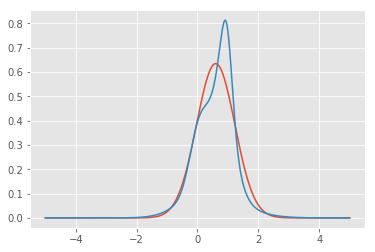

In [163]:

a = np.random.uniform(size=10)
A = np.random.uniform(size=10)**2

p = np.random.uniform(size=10)
p /= p.sum()

m = np.sum(p*a)
M = np.sum(p*(A + a*a - m*m))

x = np.linspace(-5,5,1000)

y = np.sum([pi*np.exp(-0.5*(x - ai)**2/Ai)/np.sqrt(2*np.pi*Ai) for (pi,ai,Ai) in zip(p,a,A)], axis=0)
print(y.sum())
# y /= y.sum()

Y = np.exp(-0.5*(x-m)**2 / M)/np.sqrt(2*np.pi*M)
print(Y.sum())
# Y /= Y.sum()

print(m,M)

plt.plot(x,Y)
plt.plot(x,y)
plt.show()
